# Machine Learning.
## Parte 2. Problema de Regresión
### Autor:   Jesús González Leal   
### <div align="right"> Fecha: 14 de Diciembre del 2018 </div>

El objetivo es **estimar el precio** ( price ) de un diamante a partir de un conjunto de
propiedades físicas del mismo:
    
- carat : peso del diamante
- cut : calidad del corte: Fair, Good, Very good, Premium, Ideal.
- color : desde color J (peor color) a D (mejor color)
- clarity : medida de la claridad del diamante (I1 (peor calidad), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (mejor claridad))
- x : longitud en mm
- y : anchura en mm.
- z : profundidad en mm
- depth : porcentaje de profundidad total 2 * z / (x + y)
- table : ancho de la punta del diamante relativa al punto más ancho.

--------------------

# Carga del dataset y exploración de las variables

In [1]:
# Carga de las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.colors import ListedColormap
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Carga del dataset:
data = pd.read_csv('../practica/diamonds.csv', sep=',', decimal='.')
data.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


De la observación directa del dataset ya podemos ver que podemos eliminar la primera columna, ya que debe de ser un autonumérico que indique el número de fila del dataset.

La variable cut, color y clarity **son categóricas** y la tendremos que tratar como tal.

**price** es nuestra variable target. Después veremos como evoluciona.

Vamos a mirar el tamaño de nuestro dataset y el tipo de datos que contine.

In [3]:
data = data[data.columns[1:]]
print(data.shape)

(53940, 10)


In [4]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
carat      53940 non-null float64
cut        53940 non-null object
color      53940 non-null object
clarity    53940 non-null object
depth      53940 non-null float64
table      53940 non-null float64
price      53940 non-null int64
x          53940 non-null float64
y          53940 non-null float64
z          53940 non-null float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


No apreciamos valores nulos en las variables.

In [5]:
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Miremos la existencia de valores duplicados y nulos en las muestras.

In [6]:
data = data.drop_duplicates()
print(data.shape)
print(np.where(pd.isnull(data)))
print(np.where(pd.isna(data)))


(53794, 10)
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


No parece que existan valores nulos.

# Preprocesamiento de las variables

 ## Codificación de las variables categóricas

In [7]:
index=[]
for i, d in enumerate(data.dtypes):
    if d == 'object':
        print(i, d)
        index.append(i)

print('Categorical labels: ', data.columns[index])

1 object
2 object
3 object
Categorical labels:  Index(['cut', 'color', 'clarity'], dtype='object')


La variables anteriores son categóricas y las tendremos que codificar para que los algoritmos puedan interpretarlas. También vamos a mostrar el vector de orden de codificación, por si fuera necesario.

Las variables categóricas tienen un orden de prioridad establecido que respetaremos tras la codificación numérica.

In [8]:
# Encoding the categoric labels.
# cut Encoding: Fair, Good, Very good, Premium, Ideal.
print(np.unique(data['cut']))
cut_encoding = {'cut':{'Fair':0, 'Good':1, 'Very Good':2, 'Premium':3, 'Ideal':4}}
data.replace(cut_encoding, inplace=True)
print(np.unique(data['cut']))
print()

# color: J (peor color) a D (mejor color)
print(np.unique(data['color']))
color_encoding = {'color':{'J':0, 'I':1, 'H':2, 'G':3, 'F':4, 'E':5, 'D':6}}
data.replace(color_encoding, inplace=True)
print(np.unique(data['color']))
print()

# clarity: I1 (peor calidad), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (mejor claridad)
print(np.unique(data['clarity']))
clarity_encoding = {'clarity': {'I1':0, 'SI2':1, 'SI1':2, 'VS2':3, 'VS1':4, 
                    'VVS2':5, 'VVS1':6, 'IF':7 }}
data.replace(clarity_encoding, inplace=True)
print(np.unique(data['clarity']))
print()




['Fair' 'Good' 'Ideal' 'Premium' 'Very Good']
[0 1 2 3 4]

['D' 'E' 'F' 'G' 'H' 'I' 'J']
[0 1 2 3 4 5 6]

['I1' 'IF' 'SI1' 'SI2' 'VS1' 'VS2' 'VVS1' 'VVS2']
[0 1 2 3 4 5 6 7]



## Análisis Exploratorio de las variables

Empezaremos nuestro análisis por la variable target **price**.

count    53794.000000
mean      3933.065082
std       3988.114460
min        326.000000
25%        951.000000
50%       2401.000000
75%       5326.750000
max      18823.000000
Name: price, dtype: float64


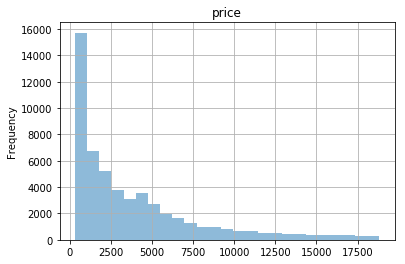

In [9]:
print(data.price.describe().T)
#data.price.hist()

plt.figure()
#plt.subplot(2,2,1)
data.price.plot.hist(alpha=0.5, bins=25, grid = True)
plt.title('price')

plt.show()

Vemos que la distribución de la muestra se encuentra muy escorada hacia la izquierda. Vamos a tratar de comprobar si es posible encontrar otra distribución que se le ajuste. Para ello vamos a intentar normalizarla aplicando **una transformación logarítmica**.

Posteriormente, hemos aplicado **un Test de Shapiro-Wild** para comprobar la normalidad de la variable target. 

(0.96355801820755, 0.0)


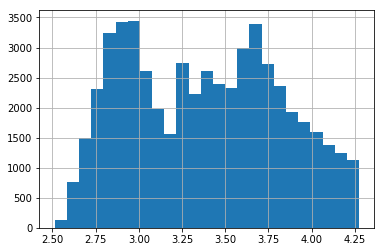

In [10]:
from scipy import stats
y_log = np.log10(data.price)
print(stats.shapiro(y_log))
y_log.hist(bins=25)

Dado el resultado del p-valor, y la forma de la figura, rechazamos la hipótesis de normalidad de la muestra.
Lamentablemente no hemos conseguido una normalidad de la variable target con la transformación.

Lo que si se puede considerar es la **estandarización** de las variables predictoras, ya que **tenemos mezcladas varias unidades de medida diferentes.**

Otra opción que podemos intentar es a filtrar los datos por la derecha. Examinando su mediana, con 2400  por pieza, podemos cortar en 4000 , con lo que nos quedaríamos con algo menos del 75 % de las muestras

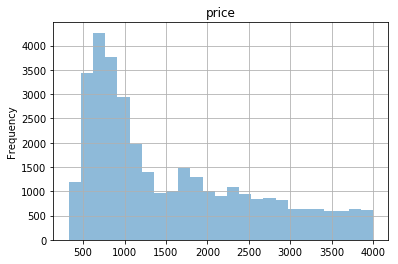

In [11]:
data_filtraded = data[data.price<4000]

plt.figure()
#plt.subplot(2,2,1)
data_filtraded.price.plot.hist(alpha=0.5, bins=25, grid = True)
plt.title('price')

plt.show()

(0.9567750692367554, 0.0)


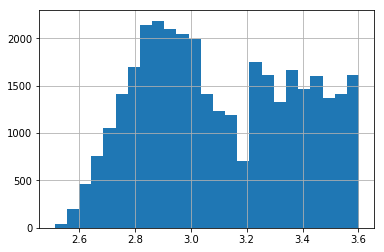

In [12]:
y_log = np.log10(data_filtraded.price)
print(stats.shapiro(y_log))
y_log.hist(bins=25)

Vemos que no conseguimos ninguna mejoría en la normalidad, por lo que descartamos esta aproximación.

## Análisis de correlación

   Lanzamos el análisis de correlación sobre todo el dataset.

In [13]:
data.corr()

,carat,cut,color,clarity,depth,table,price,x,y,z
carat,1.000000,-0.133376,-0.291019,-0.352288,0.027861,0.181091,0.921548,0.975380,0.951908,0.953542
cut,-0.133376,1.000000,0.020162,0.188327,-0.217078,-0.433700,-0.052241,-0.124303,-0.120233,-0.147940
color,-0.291019,0.020162,1.000000,-0.025542,-0.047572,-0.026102,-0.171825,-0.269876,-0.263153,-0.267825
clarity,-0.352288,0.188327,-0.025542,1.000000,-0.067292,-0.160000,-0.146149,-0.371636,-0.358048,-0.366568
depth,0.027861,-0.217078,-0.047572,-0.067292,1.000000,-0.297669,-0.011048,-0.025348,-0.029389,0.094757
table,0.181091,-0.433700,-0.026102,-0.160000,-0.297669,1.000000,0.126566,0.194855,0.183231,0.150270
price,0.921548,-0.052241,-0.171825,-0.146149,-0.011048,0.126566,1.000000,0.884504,0.865395,0.861208
x,0.975380,-0.124303,-0.269876,-0.371636,-0.025348,0.194855,0.884504,1.000000,0.974592,0.970686
y,0.951908,-0.120233,-0.263153,-0.358048,-0.029389,0.183231,0.865395,0.974592,1.000000,0.951844
z,0.953542,-0.147940,-0.267825,-0.366568,0.094757,0.150270,0.861208,0.970686,0.951844,1.000000


Apreciamos como la variable **'carat'**, junto con las medidad del diamante **'x', 'y', 'z',** tiene una correlación muy fuerte con la variable de salida.

A su vez, estas cuatro variables están tambien correlacionadas entre ellas.

Tiene sentido el pensar que el precio del diamante está directamente relacionado con sus medidas y con su peso.

Dado que estamos hablando de un mismo objeto, diamante, al que suponemos una densidad constante, podemos agrupar las cuatro variables en **una variable de volumen**. Tendremos que tener en cuenta sus unidades cúbicas.

In [14]:
data['vol'] = data['x']*data['y']*data['z']
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,vol
0,0.23,4,5,1,61.5,55.0,326,3.95,3.98,2.43,38.202030
1,0.21,3,5,2,59.8,61.0,326,3.89,3.84,2.31,34.505856
2,0.23,1,5,4,56.9,65.0,327,4.05,4.07,2.31,38.076885
3,0.29,3,1,3,62.4,58.0,334,4.20,4.23,2.63,46.724580
4,0.31,1,0,1,63.3,58.0,335,4.34,4.35,2.75,51.917250


Ahora, ya podemos eliminar las variables correlacionadas

In [15]:
data=data.drop(['carat', 'x', 'y', 'z'], axis=1)
data.head()

,cut,color,clarity,depth,table,price,vol
0,4,5,1,61.5,55.0,326,38.202030
1,3,5,2,59.8,61.0,326,34.505856
2,1,5,4,56.9,65.0,327,38.076885
3,3,1,3,62.4,58.0,334,46.724580
4,1,0,1,63.3,58.0,335,51.917250


Y volvemos a lanzar un análisis de correlación sobre las variables.

In [16]:
data.corr()

,cut,color,clarity,depth,table,price,vol
cut,1.000000,0.020162,0.188327,-0.217078,-0.433700,-0.052241,-0.116803
color,0.020162,1.000000,-0.025542,-0.047572,-0.026102,-0.171825,-0.283789
clarity,0.188327,-0.025542,1.000000,-0.067292,-0.160000,-0.146149,-0.340515
depth,-0.217078,-0.047572,-0.067292,1.000000,-0.297669,-0.011048,0.008704
table,-0.433700,-0.026102,-0.160000,-0.297669,1.000000,0.126566,0.166813
price,-0.052241,-0.171825,-0.146149,-0.011048,0.126566,1.000000,0.902231
vol,-0.116803,-0.283789,-0.340515,0.008704,0.166813,0.902231,1.000000


La correlación entre el volumen de la pieza y el precio es muy fuerte!

### Histogramas

Pintamos histogramas para cada clase predictora.

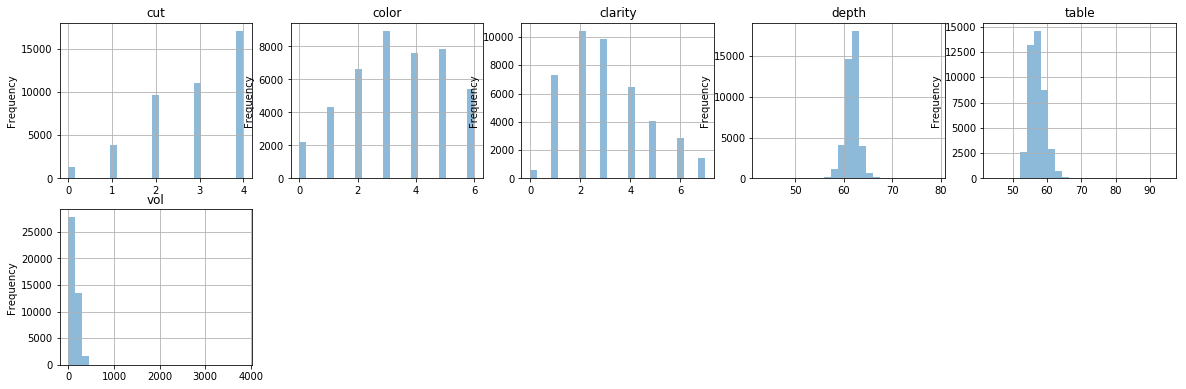

In [19]:
X_columns = data.columns.drop('price')
X_columns
X = X_train[X_columns]

plt.figure(figsize=(20,20))

for i,feature in enumerate(X.columns):
    plt.subplot(6,5,i+1)   
    X[feature].plot.hist(alpha=0.5, bins=25, grid = True)
    plt.title(feature)
    
plt.show()

# Etapa de Aprendizaje

## Separación de datos en Entrenamiento y Test.

In [20]:
from sklearn.model_selection import train_test_split

# Dividimos los datos en entrenamiento y test (80 training, 20 test)
# Utilizamos el valor de shuffle para mezclar los datos
y = data['price']
X = data.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,  random_state = 0)

print('Datos entrenamiento: ', X_train.shape)
print('Datos test: ', X_test.shape)

Datos entrenamiento:  (43035, 6)
Datos test:  (10759, 6)


### Estandarización de las variables predictoras

Ahora si aplicamos una estadarización de las variables, evitando el impacto de trabajar con unidades diferentes.

In [21]:
# Stantard procedure over the training data
from sklearn import preprocessing

X_columns = data.columns.drop('price')
X_columns
X = X_train[X_columns]

# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_df = scaler.fit_transform(X)
X_s = pd.DataFrame(scaled_df, columns=X_columns)

X_s.head()

,cut,color,clarity,depth,table,vol
0,0.085168,1.520630,-1.246629,0.244989,0.689823,-1.009613
1,-0.812504,-2.005281,-0.029471,1.017086,1.138421,-0.624951
2,-0.812504,0.932978,-0.638050,-1.158823,1.587018,-1.010827
3,-0.812504,-1.417629,0.579108,-0.597298,-0.207371,-1.062647
4,0.982839,-0.829977,-0.638050,-0.386726,-1.059706,-0.838121


## Regresión mediante regresión lineal múltiple

Vamos a probar el comportamiento predictivo con una regresión lineal de múltiples variables. En nuestro modelo tenemos 6 variables predictivas, después de haber sustituido las variables relativas a la dimensión del diamante por una sólo variable de volumen.

In [189]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

features = data.columns.drop('price')
lrModel = LinearRegression().fit(X_train, y_train)

ytrainLineal = lrModel.predict(X_train)
y_predict  = lrModel.predict(X_test)

rmseTrainModel = np.sqrt(mean_squared_error(y_train,ytrainLineal))
rmseTestModel = np.sqrt(mean_squared_error(y_test,y_predict))

print('RMSE Regresión lineal (train): %0.3g' % rmseTrainModel)
print('RMSE Regresión lineal (test) : %0.3g' % rmseTestModel)
print ('R2: ', r2_score(y_test, y_predict))
print()
print('Coecifient value: ')
w = lrModel.coef_
for f,wi in zip(features,w):
    print(f,wi)

print("Intercept value: ", lrModel.intercept_)

RMSE Regresión lineal (train): 1.57e+03
RMSE Regresión lineal (test) : 1.27e+03
R2:  0.8997644426762768

Coecifient value: 
cut 114.33824117941538
color 266.62120112685534
clarity 458.2173708932736
depth 24.87089007575959
table 18.67201002798796
vol 50.52792815386118
Intercept value:  -7869.788843471151


Como podemos comprobar, el Root mean square error (RMSE) que obtenemos en la predicción de regresión es muy alto. 

Este modelo nos servirá de base para poder comparar con otros modelos.

### Selección de características

Vamos a intentar mejorar el modelo utilizando una selección de características. Seleccionaremos las 2 características más significativas **según su F-score.**


In [190]:
from  sklearn.feature_selection import SelectKBest, f_regression

#Feature Selection

# Create and fit selector
selector = SelectKBest(f_regression, k=2).fit(X_s, y_train)

# Get idxs of columns to keep
cols = selector.get_support(indices=True)
for i in cols:
    print('Columna escogida: ', X_s.columns[i])

X_one_train= X_train.drop(['cut', 'clarity', 'depth', 'table'], axis=1)
X_one_test= X_test.drop(['cut', 'clarity', 'depth', 'table'], axis=1)
print('Train: ', X_one_train.shape)
print('Test: ', X_one_test.shape)

Columna escogida:  color
Columna escogida:  vol
Train:  (43035, 2)
Test:  (10759, 2)


In [191]:
lrModel_one = LinearRegression().fit(X_one_train, y_train)

ytrainLineal = lrModel_one.predict(X_one_train)
y_predict  = lrModel_one.predict(X_one_test)

rmseTrainModel = np.sqrt(mean_squared_error(y_train,ytrainLineal))
rmseTestModel = np.sqrt(mean_squared_error(y_test,y_predict))

print('RMSE Regresión lineal selected (train): %0.3g' % rmseTrainModel)
print('RMSE Regresión lineal selected (test) : %0.3g' % rmseTestModel)
print ('R2: ', r2_score(y_test, y_predict))
print()
print("Intercept value: ", lrModel.intercept_)

RMSE Regresión lineal selected (train): 1.72e+03
RMSE Regresión lineal selected (test) : 1.51e+03
R2:  0.8571547448162784

Intercept value:  -7869.788843471151


La selección de características mediante este método **no nos ha arrojado mejor resultado.**   
Por tanto, teniendo en cuenta que la dimensionalidad de la muestra no es muy alta, alimentaremos los modelos predictivos con todas las variables.

## Regresión mediante árbol de decisión

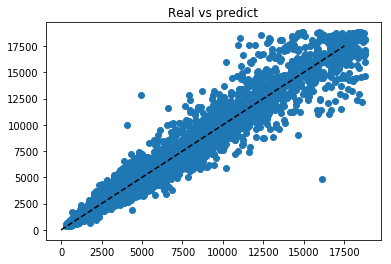

RMSE:  714.18  $
R2:  0.9681


In [192]:
from sklearn.tree import DecisionTreeRegressor


regTree = DecisionTreeRegressor(criterion='mse')
# Entrenamos el modelo
regTree.fit(X_train,y_train)
# Predicción con los datos de test
y_predict = regTree.predict(X_test)
# Calculamos el Root Mean Square Error 

#error = np.round(np.sqrt(np.power(y_test -y_predict,2)),2)
RMSE = np.round(np.sqrt(np.mean(np.power(y_test -y_predict,2))),2)
plt.scatter( y_test, y_predict)
#plt.plot(error, color='red')
plt.plot([0, 17500], [0, 17500], color='black', linestyle='--')

plt.title('Real vs predict')
plt.show()

print('RMSE: ', RMSE, ' $')
print ('R2: ', round(r2_score(y_test, y_predict),4))

Hemos podido mejorar nuestro error cuadrático medio obteniendo un valor de R<sup>2</sup> muy bueno.

Vamos a probar a entrenar de nuevo nuestro árbol de decisión, pero esta vez vamos a jugar con el parámetro que controla **la profundidad del árbol**, utilizando validación cruzada.

best mean cross-validation score: 0.941
best parameters: {'max_depth': 18}


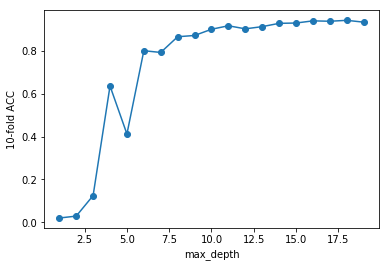

In [193]:
from sklearn.model_selection import GridSearchCV
maxDepth = range(1,20)
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(DecisionTreeRegressor(random_state=0, criterion='mse', max_features='sqrt'), param_grid=tuned_parameters,cv=10) 
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()


Los datos de test nos acabarán de decir que tal bueno es este modelo.

In [194]:
maxDepthOptimo = grid.best_params_['max_depth']
regtree = DecisionTreeRegressor(criterion='mse', max_depth=maxDepthOptimo).fit(X_train,y_train)

print("R2 Train: ",regtree.score(X_train,y_train))
print("R2 Test: ",regtree.score(X_test,y_test))

R2 Train:  0.9976855035731991
R2 Test:  0.9695165633172401


El modelo se encuentra **sobreajustado**. Forzando un valor más bajo de profundidad nos podremos alejar del overfitting.

In [195]:
regtree = DecisionTreeRegressor(criterion='mse', max_depth=12).fit(X_train,y_train)

print("R2 Train: ",regtree.score(X_train,y_train))
print("R2 Test: ",regtree.score(X_test,y_test))

R2 Train:  0.9875782600648634
R2 Test:  0.9758529563427292


Bajando la profundidad nos encontramos con que ha mejorado las prestaciones de nuestro modelo.

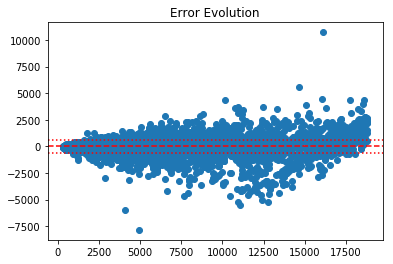

RMSE Regresion Tree (test) : 621
R2:  0.9759


In [196]:
y_predict = regtree.predict(X_test)
y_error = np.array(y_test)
y_error = y_test - y_predict

RMSE = np.round(np.sqrt(np.mean(np.power(y_test -y_predict,2))),2)
R2 = round(r2_score(y_test, y_predict),4)

plt.scatter(y_test, y_error)
plt.axhline(y=RMSE, color='r', linestyle=':')
plt.axhline(y=0, color='r', linestyle='--')
plt.axhline(y=(-1)*RMSE, color='r', linestyle=':')
plt.title('Error Evolution')
plt.show()

print('RMSE Regresion Tree (test) : %0.3g' % RMSE)
print ('R2: ', R2)

En el gráfico superior mostramos la evolución del error cometido al predecir sobre los datos de TEST. Se ha marcado con líneas discontinuas el valor de error medio obtenido.

## Regresión mediante Boosted Tree

Como parámetros libres tenemos el número de árboles, la tasa de aprendizaje y la profundidad del árbol.

Tasa de aprendizaje y número de árboles están inversamente relacionados. 

Se recomienda que la profundidad de los árboles sea pequeña. Valores entre 2 y 5 serían ideales.

Por tanto, vamos a fijar la profundidad a 3 e iremos iterando para encontrar el mejor juego de parámetros libres.

In [197]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

Niterations = [500,1000,1500,2000, 2500, 3000]
learningRate = [0.1,0.05, 0.01]
# mantenemos max_depth estático: max_depth=3

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate }
grid = GridSearchCV(GradientBoostingRegressor(random_state=0, max_depth=3), param_grid=param_grid, cv = 5)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

best mean cross-validation score: 0.978
best parameters: {'learning_rate': 0.05, 'n_estimators': 2000}


El mejor score de 0.978 lo hemos obtenido para una tasa de aprendizaje del 0.05 y con 2500 iteraciones.     
Graficando el resultado obtenido:

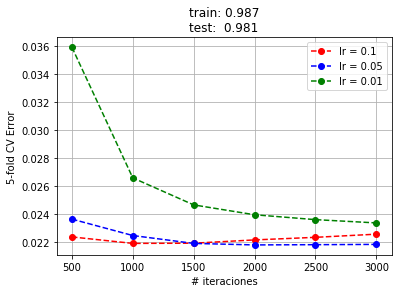

In [198]:
bt = GradientBoostingRegressor(random_state=0, max_depth=3,learning_rate= 0.05, n_estimators= 2500)
bt.fit(X_train,y_train)

error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate),len(Niterations))
colors = ['r','b','g','k','m']
for i,lr in enumerate(learningRate):    
    plt.plot(Niterations,error[i,:],colors[i] + '--o',label='lr = %g'%lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('5-fold CV Error')
plt.title('train: %0.3f\ntest:  %0.3f'%(bt.score(X_train,y_train),bt.score(X_test,y_test)))
plt.grid()
plt.show()

Es interesante ver el comportamiento de lr=0.01. Este sería el comportamiento ideal de la tasa de aprendizaje. Podríamos pensar, y así parece, <u> que la asíndota que limita el error de la curva </u>se obtiene para un valor muy superior a 3.000 iteraciones, y vernos tentados en aumentar a un número por encima de este valor, pero <u>esta decisión complicaría el modelo en tiempo de computación</u>.   

Un lr= 0.1 converge con el lr=0.05 en 1.500 iteraciones, siendo este el mínimo de la curva. A partir de allí, la tasa de aprendizaje se incrementa.

Es por ello, que hemos **fijado el lr a 0.05**, manteniéndose el error estable a partir de las 2.000 iteraciones. Lo que nos ofrece una modelo más robusto.

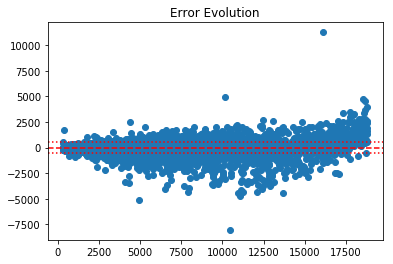

RMSE Boosted Tree (test) : 554
R2:  0.9808


In [199]:
y_predict = bt.predict(X_test)
y_error = np.array(y_test)
y_error = y_test - y_predict

RMSE = np.round(np.sqrt(np.mean(np.power(y_test -y_predict,2))),2)
R2 = round(r2_score(y_test, y_predict),4)

plt.scatter(y_test, y_error)
plt.axhline(y=RMSE, color='r', linestyle=':')
plt.axhline(y=0, color='r', linestyle='--')
plt.axhline(y=(-1)*RMSE, color='r', linestyle=':')
plt.title('Error Evolution')
plt.show()

print('RMSE Boosted Tree (test) : %0.3g' % RMSE)
print ('R2: ', R2)

Como podemos observar, obtenemos un buen resultado fijando el modelo a los parámetros encontrados anteriormente.

## Regresión mediante Support Vector Regression.

### SVR Lineal

Vamos a utlizar un kernel lineal para comprobar su funcionamiento. 
Los parámetros libres del SVR para regresión, son: **C  y epsilon**.    
Con C penalizamos los errores, y con Épsilon vamos a controlar el margen de error permitido. Este último parámetro, Épsilon, está relacionado con la sensibilidad que queramos permitir al modelo.    
Viendo que el mejor RMSE conseguido hasta ahora está en algo menos de 600, tomaremos este valor como referencia.

In [200]:
from sklearn.svm import LinearSVR
import pickle

vectorC = np.logspace(-2, 2, 10)
vectorE = [800, 1000, 1500]

param_grid = {'C': vectorC, 'epsilon':vectorE}

grid = GridSearchCV(LinearSVR(epsilon=0), param_grid=param_grid, cv = 10, verbose=1)
grid.fit(X_train, y_train)

# Persistence layer
filename = 'LinearSVRmodel'
outfile = open(filename,'wb')
pickle.dump(grid,outfile)
outfile.close()

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 16.0min finished


best mean cross-validation score: 0.845
best parameters: {'C': 0.5994842503189409, 'epsilon': 800}


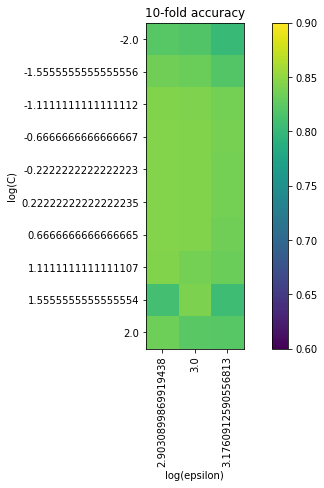

In [201]:
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

# Mostramos prestaciones en CV
scores = grid.cv_results_['mean_test_score'].reshape(len(vectorC),len(vectorE))

plt.figure(figsize=(10,6))
plt.imshow(scores, interpolation='nearest', vmin= 0.6, vmax=0.9)
plt.xlabel('log(epsilon)')
plt.ylabel('log(C)')
plt.colorbar()
plt.xticks(np.arange(len(vectorE)), np.log10(vectorE), rotation=90)
plt.yticks(np.arange(len(vectorC)), np.log10(vectorC))
plt.title('10-fold accuracy')
plt.show()

In [202]:
Best_C = grid.best_params_['C']
Best_Epsilon = grid.best_params_['epsilon']

SVRlineal= LinearSVR( C=Best_C, epsilon=Best_Epsilon).fit(X_train, y_train)

print("R2 Train: ",SVRlineal.score(X_train,y_train))
print("R2 Test: ",SVRlineal.score(X_test,y_test))

R2 Train:  0.8436405095988923
R2 Test:  0.9001079866910573


Best Lineal SVR Kernel Results: C=6; epsilon= 1000; R2 Train:  0.8269;  R2 Test: 0.8756

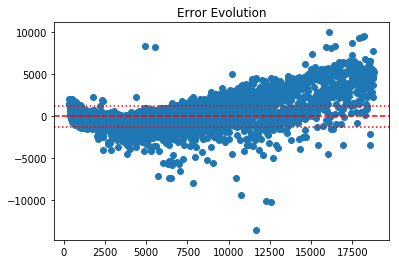

RMSE Boosted Tree (test) : 1.26e+03
R2:  0.9001


In [203]:
y_predict = SVRlineal.predict(X_test)
y_error = np.array(y_test)
y_error = y_test - y_predict

RMSE = np.round(np.sqrt(np.mean(np.power(y_test -y_predict,2))),2)
R2 = round(r2_score(y_test, y_predict),4)

plt.scatter(y_test, y_error)
plt.axhline(y=RMSE, color='r', linestyle=':')
plt.axhline(y=0, color='r', linestyle='--')
plt.axhline(y=(-1)*RMSE, color='r', linestyle=':')
plt.title('Error Evolution')
plt.show()

print('RMSE Boosted Tree (test) : %0.3g' % RMSE)
print ('R2: ', R2)

Es cusioso que en este modelo estemos obteniendo mejores valores de R<sup>2</sup> en test que en train. En todo caso, el RMSE obtenido se dispara con respecto las anteriores aproximaciones. Se ha probado aumentando con diferentes valores de Epsilon, y se se ha visto que el valor máximo se optiene para Epsilon=1000. Forzando a un valor inferior, no se consigue correguir la desigualdad de R<sup>2</sup> entre train y test.

Observando en la gráfica como evoluciona el error, vemos como para valores más altos de 10.000 $, éste tiende a aumentar positivamente en exceso.

### SVR Polynomial kernel

Se ha comprobado que un kernel lineal no ofrece unos resultados aceptables. Esto puede ser debido a que este tipo de kernel es bastante rígido. 
Un modelo polinómico permite una mejor adaptación a las variaciones. 
*(Tarda lo suyo ...)*

* Con verbose=2 se puede ver como en mi máquina tarda 1 mín. por cada iteración con gamma= auto. *
* Time = NumC x NumD x cv x 1 min *


- Primera ejecución: gamma fijado a auto. Barremos el parámetro de penalización del error C y el grado del polinomio
    - vectorC = np.logspace(-2, 3, 5)
    - vectorD = [1,2,3]
    - Results: C=100, degree=1; R2 Train:  0.8178; R2 Test:  0.8589
- Segunda ejecución: Una vez fijado C y degree, barremos para gamma.
    - vectorD = 1
    - vectorC = 100
    - vectorG = np.logspace(-2, 2, 5)
    - Results: 'C': 100, 'degree': 1, 'gamma': 100.0; R2 Train:  0.8178; R2 Test:  0.8589

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import pickle

#vectorC = np.logspace(-2, 2, 5)
vectorD = [1]
vectorC = [100]
vectorG = np.logspace(-2, 2, 5)
#vectorD = [3]

param_grid = {'C': vectorC, 'degree':vectorD, 'gamma': vectorG}

grid = GridSearchCV(SVR(kernel= 'poly', epsilon=0), param_grid=param_grid, cv = 5, n_jobs=2, verbose=2)

grid.fit(X_train, y_train)

# Persistence layer
filename = 'SVR_poly'
outfile = open(filename,'wb')
pickle.dump(grid,outfile)
outfile.close()

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best Value Selected:

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0,
  gamma='auto_deprecated', kernel='poly', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

best mean cross-validation score: 0.819
best parameters: {'C': 100, 'degree': 1, 'gamma': 100.0}


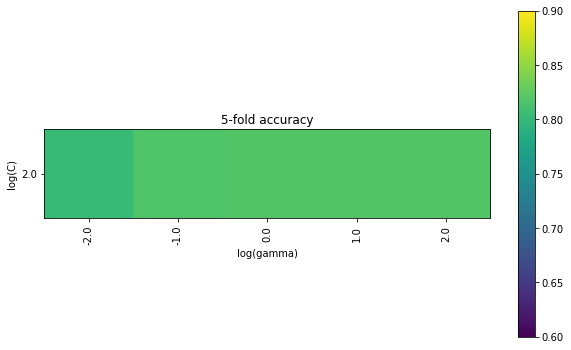

In [248]:
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

# Mostramos prestaciones en CV
scores = grid.cv_results_['mean_test_score'].reshape(len(vectorC),len(vectorG))

plt.figure(figsize=(10,6))
plt.imshow(scores, interpolation='nearest', vmin= 0.6, vmax=0.9)
plt.xlabel('log(gamma)')
plt.ylabel('log(C)')
plt.colorbar()
plt.xticks(np.arange(len(vectorG)), np.log10(vectorG), rotation=90)
plt.yticks(np.arange(len(vectorC)), np.log10(vectorC))
plt.title('5-fold accuracy')
plt.show()

In [249]:
Best_C = grid.best_params_['C']
Best_Degree = grid.best_params_['degree']

SVR_poly= SVR(kernel='poly', C= Best_C, degree=Best_Degree).fit(X_train, y_train)

print("R2 Train: ",SVR_poly.score(X_train,y_train))
print("R2 Test: ",SVR_poly.score(X_test,y_test))

R2 Train:  0.8178206784684994
R2 Test:  0.8589803099707038


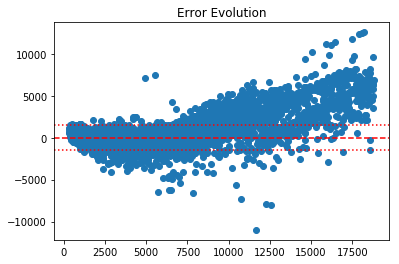

RMSE Boosted Tree (test) : 1.5e+03
R2:  0.859


In [250]:
y_predict = SVR_poly.predict(X_test)
y_error = np.array(y_test)
y_error = y_test - y_predict

RMSE = np.round(np.sqrt(np.mean(np.power(y_test -y_predict,2))),2)
R2 = round(r2_score(y_test, y_predict),4)

plt.scatter(y_test, y_error)
plt.axhline(y=RMSE, color='r', linestyle=':')
plt.axhline(y=0, color='r', linestyle='--')
plt.axhline(y=(-1)*RMSE, color='r', linestyle=':')
plt.title('Error Evolution')
plt.show()

print('RMSE Boosted Tree (test) : %0.3g' % RMSE)
print ('R2: ', R2)

Tal y como nos pasaba en el SVR lineal, el error se mantiene más o menos concentrado para valores por debajo de 7.500 $. A partir de aquí, el comportamiento del error cometido por el modelo es a evolucionar positivamente haciendo que el RMSE crezca en demasía.

# Conclusiones

A continuación se expone una tabla con las métricas por modelo encontradas.  


| Modelo |R <sup>2</sup> | RMSE |
| ------ | --- | --- |
| Regresión Lineal | 0.90 | 1.27 k |
| Regresión Lineal 2 var. | 0.86 | 1.51 k |
| árbol de decisión | 0.98 | 621 |
| Boosted Tree | 0.98 | 554 |
| SVR lineal | 0.90 | 1.26 k |
| SVR Polynomial |  0.86 | 1.5 k |

Los modelos basados en árboles de decisión son los que mejor métrica nos ofrecen, por encima de los basados en regresión lineal o polinomial.   
De los dos modelos probados, **Boosted Tree** nos ofrece un modelo con un error medio más bajo, aunque es de notar que la simplicidad del **árbol de decisión** nos ofrezca unas métricas tan buenas.

Visto el comportamiento de la evolución del error en los modelos SVR, se podría realizar un filtraje para entrenar estos modelos con datos hasta 7.500 $ y ver si podemos mejorar sus prestaciones.